<a href="https://colab.research.google.com/github/upinder-sangha/Image-Captioning/blob/main/COMP_6341_CV_PROJECT_PHASE_1_RES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Phase 1: Getting the data ready

##Downloading the flikr8 data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp drive/MyDrive/COMP_6341_CV_PROJECT/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d adityajn105/flickr8k

100% 1.04G/1.04G [00:48<00:00, 22.0MB/s]
100% 1.04G/1.04G [00:48<00:00, 23.1MB/s]


In [ ]:
! unzip flickr8k.zip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

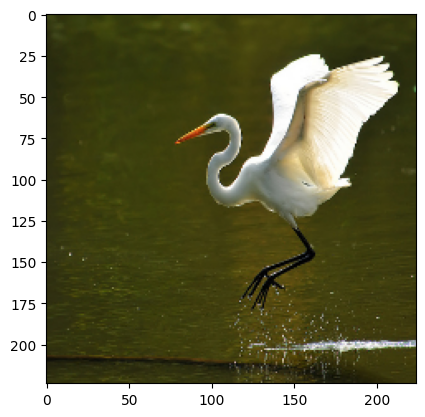

In [ ]:
image = plt.imread('Images/2860667542_95abec3380.jpg')
image = cv2.resize(image,(224,224))
plt.imshow(image)

## Extracting features from images using pretrained ResNet 50 

In [ ]:
from os import listdir
import pickle
from pickle import dump
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model

In [ ]:

def extract_feature(image_location, model):
    image = plt.imread(image_location)
    image = cv2.resize(image, (224,224))
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the resnet model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature


# extract features from each photo in the directory
def get_features_dict(directory):
    # load the model
    model = ResNet50()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # summarize
    print(model.summary())
    # extract features from each photo
    features = dict()
    i = 1
    for name in listdir(directory):
        # load an image from file
        image_location = directory + '/' + name
        feature = extract_feature(image_location, model)
        # get image id
        image_id = name.split('.')[0]

        features[image_id] = feature
        print(i,'->',name)
        i+=1
    return features
    

# extract features from all images
directory = 'Images'
features = get_features_dict(directory)
print('Extracted Features:', len(features))
# save to file
dump(features, open('features.pkl', 'wb'))

102967424/102967424 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

KeyboardInterrupt: ignored

In [ ]:
#saving those features to drive for use in next phase
!cp features.pkl drive/MyDrive/

##Cleaning the captions

In [ ]:
filename = 'captions.txt'
file = open(filename, 'r')
caption_dataset = file.read()
file.close()

In [ ]:
# extract captions for images
def get_captions_dict(caption_dataset):
    caption_dict = dict()
    # process lines
    for line in caption_dataset.split('\n'):
        tokens = line.split(".jpg,")
        if len(tokens) < 2:
            continue
        image_id = tokens[0]
        image_desc = tokens[1]
        # create the list if needed
        if image_id not in caption_dict:
            caption_dict[image_id] = list()

        caption_dict[image_id].append(image_desc)
    return caption_dict

# parse captions
captions = get_captions_dict(caption_dataset)
print('Loaded:', len(captions))
print(captions)

In [ ]:
import string
import re

def clean_captions(captions):
    total = 0
    max_length = 20
    for key, desc_list in captions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = str(desc).lower()
            desc = re.sub('[^a-z+]', ' ',desc)
            desc = desc.split()
            total = total + len(desc)
            if len(desc)>max_length:
                del desc[max_length:]
            desc = ' '.join(desc)
            desc_list[i] = desc
    print("average length = ",total/(8091*5))

# clean captions
clean_captions(captions)
print(captions)

In [ ]:
#saving the clean captions
dump(captions, open('captions.pkl', 'wb'))
!cp captions.pkl drive/MyDrive/COMP_6341_CV_PROJECT_RES/

adding  \<start> and \<end> at the starting and ending of captions

In [ ]:
for key in captions.keys():
    captions[key] = ["start "+caption+" end" for caption in captions[key]]
        
captions

##Defining training set and test set

In [ ]:
import random

image_ids = set(captions.keys())
ratio = 0.88

num_of_train = int(len(image_ids) * ratio)

# Randomly select elements for the train set
train_id_set = set(random.sample(image_ids, num_of_train))

# Create the test set by removing the elements in the train set
test_id_set = image_ids - train_id_set


print(len(train_id_set),len(test_id_set))

Splitting the features and captions into train and test

In [ ]:
train_features = {k: features[k] for k in train_id_set}
test_features = {k: features[k] for k in test_id_set}
train_captions = {k: captions[k] for k in train_id_set}
test_captions = {k: captions[k] for k in test_id_set}

In [ ]:
print("size of training set = ", len(train_captions))

In [ ]:
dump(train_features, open('train_features.pkl', 'wb'))
dump(test_features, open('test_features.pkl', 'wb'))
dump(train_captions, open('train_captions.pkl', 'wb'))
dump(test_captions, open('test_captions.pkl', 'wb'))

!cp train_features.pkl drive/MyDrive/COMP_6341_CV_PROJECT_RES/
!cp test_features.pkl drive/MyDrive/COMP_6341_CV_PROJECT_RES/
!cp train_captions.pkl drive/MyDrive/COMP_6341_CV_PROJECT_RES/
!cp test_captions.pkl drive/MyDrive/COMP_6341_CV_PROJECT_RES/